In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
plt.rcParams['figure.figsize'] = (12,6)

In [4]:
kic = 11773022 # Kepler-51

In [5]:
# KOI info
dkoi = pd.read_csv("kic%s/kic%s_koiinfo.csv"%(kic,kic))

In [11]:
# detrended light curve
d = pd.read_csv("kic%s/kic%s_long_detrend.csv"%(kic,kic))
t, f, e, fbase = np.array(d[['time', 'flux', 'error', 'flux_base']]).T

In [12]:
# transit times expected from linear ephemeris (t0 and period)
tcs, tranums, plnames = np.array([]), np.array([]), np.array([])
for i in range(len(dkoi)):
    name, t0, p = np.array(dkoi.iloc[i][['kepoi_name', 'koi_time0bk', 'koi_period']])
    tmin, tmax = np.min(t), np.max(t)
    tnum_min, tnum_max = int((tmin-t0)/p), int((tmax-t0)/p)
    tnum = np.arange(tnum_min, tnum_max+1)
    tc = t0 + p * tnum
    tcs = np.r_[tcs, tc]
    tranums = np.r_[tranums, tnum]
    plnames = np.r_[plnames, [name]*len(tc)]

In [13]:
# extract the data where |t-tc| < time_window
# ignore transits with many missing data points
time_window = 0.5 
minimum_data_frac = 0.8

/var/folders/68/h6r0kcq50914zzw8n_70l69c0000gn/T/ipykernel_94922/1434202569.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


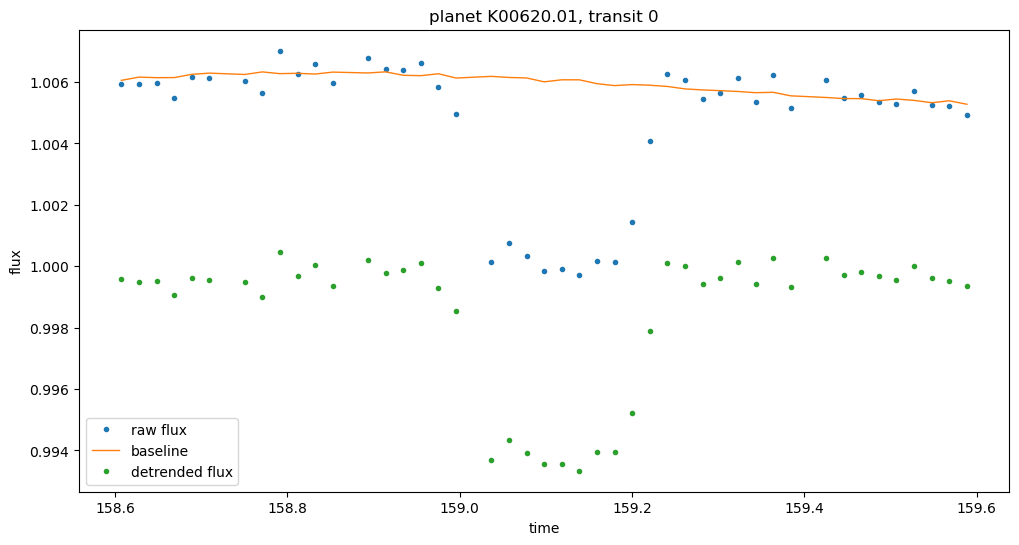

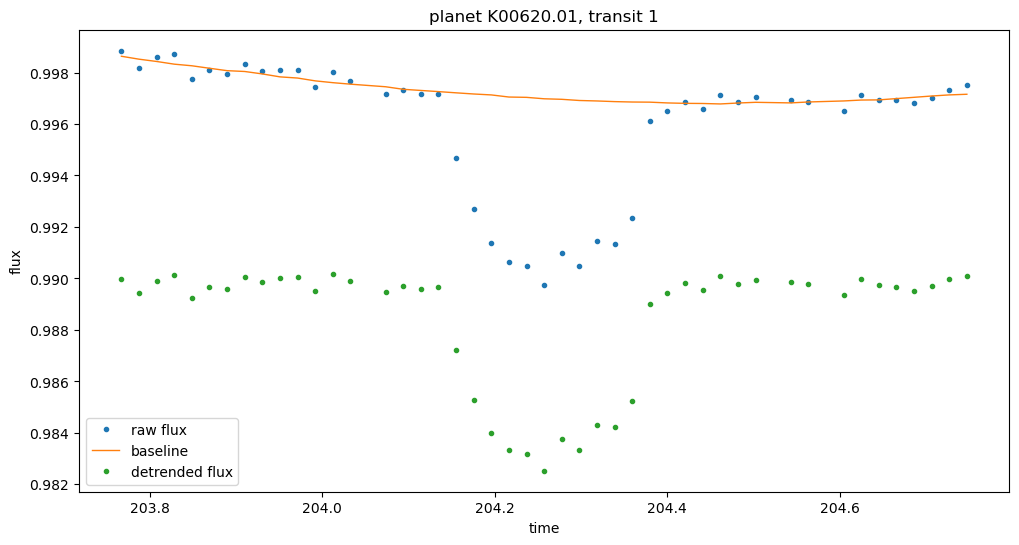

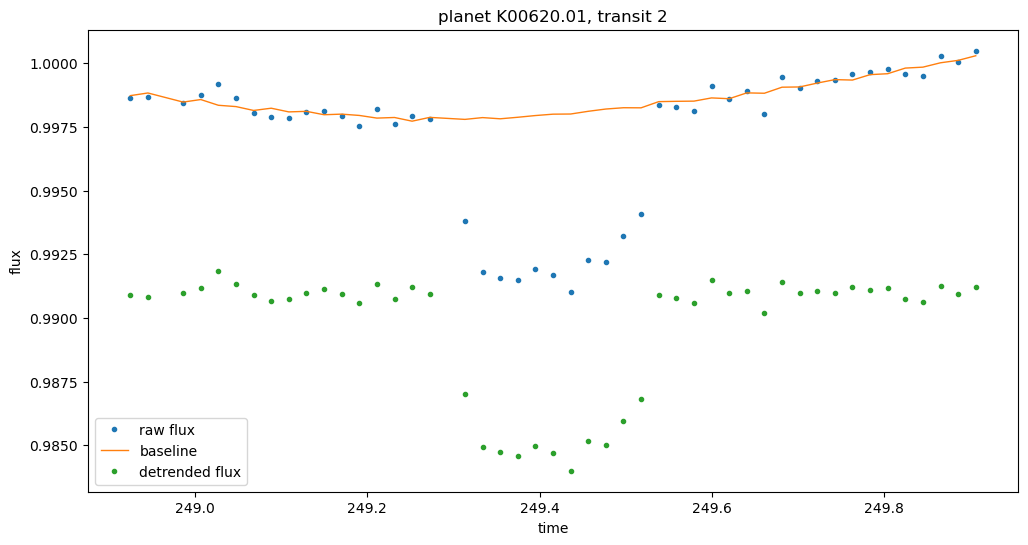

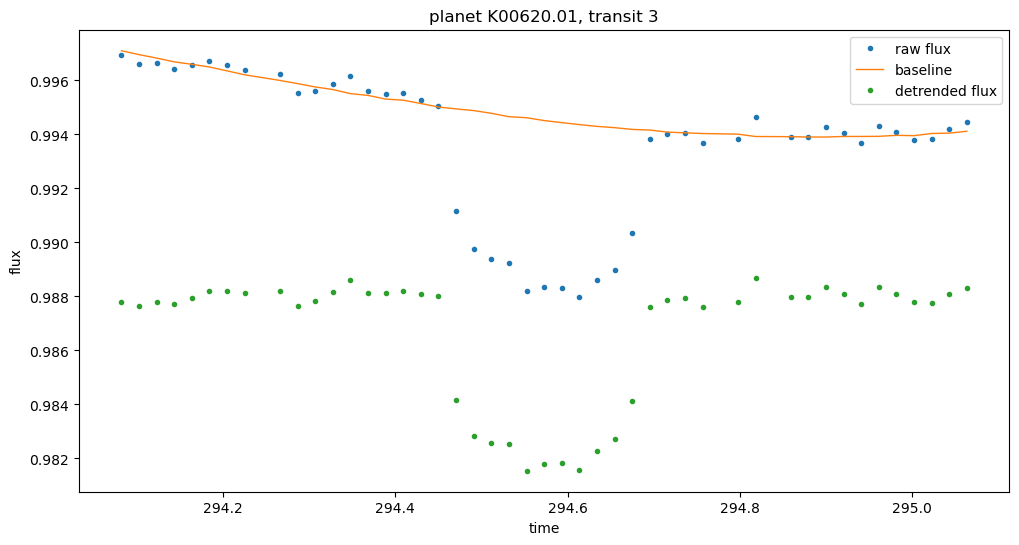

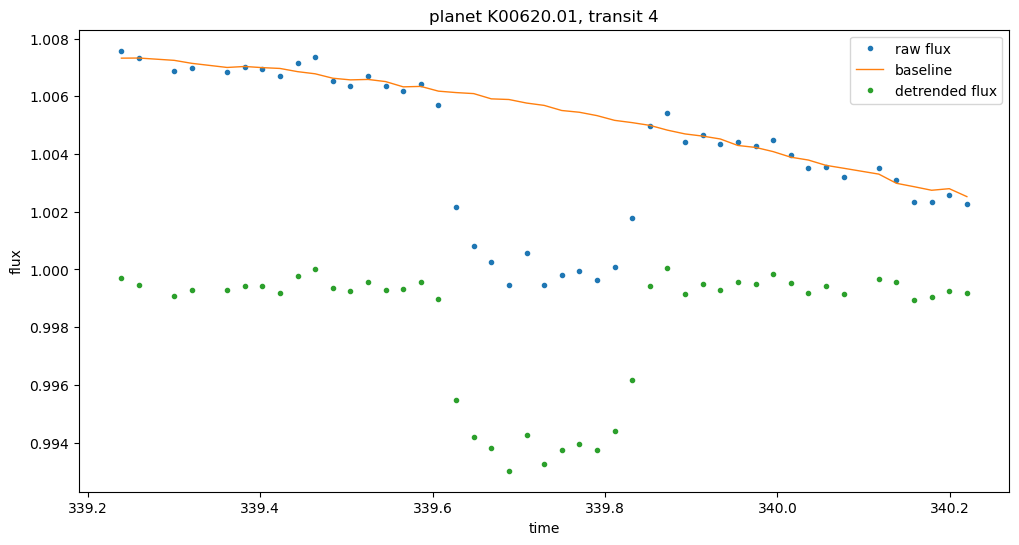

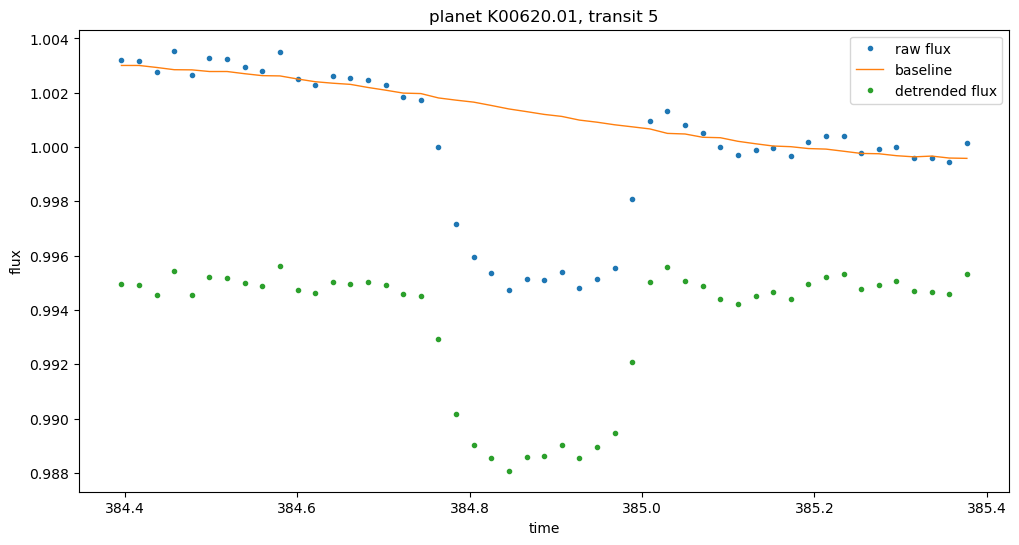

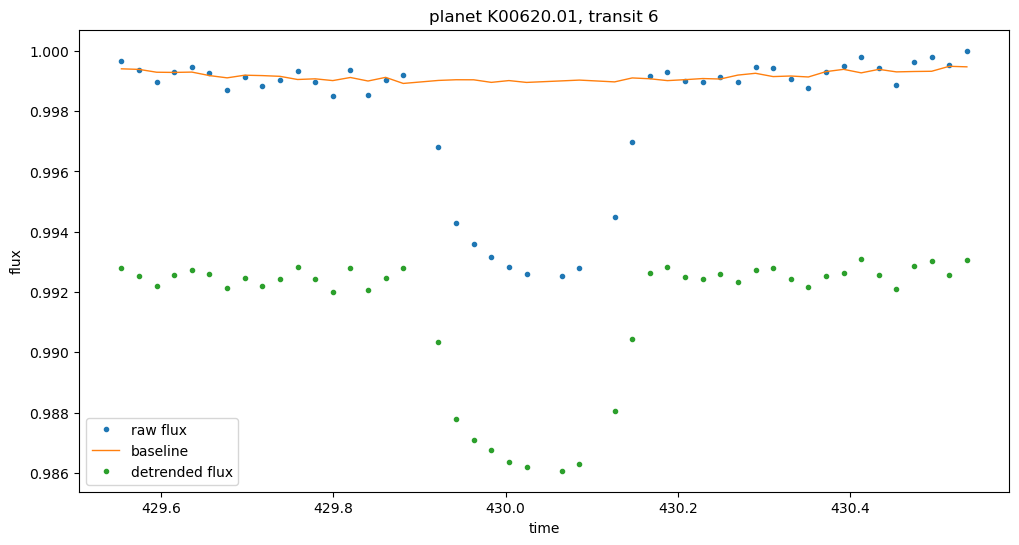

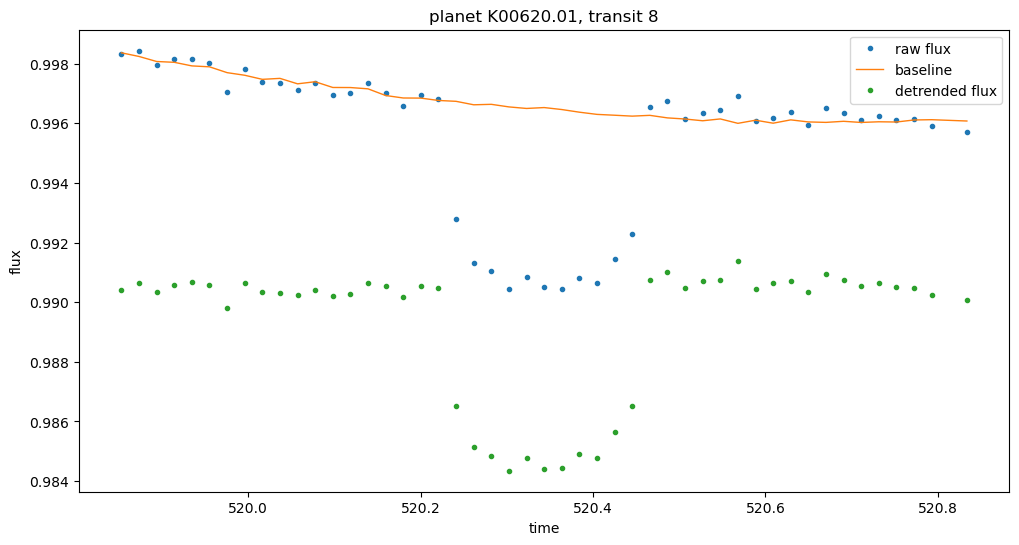

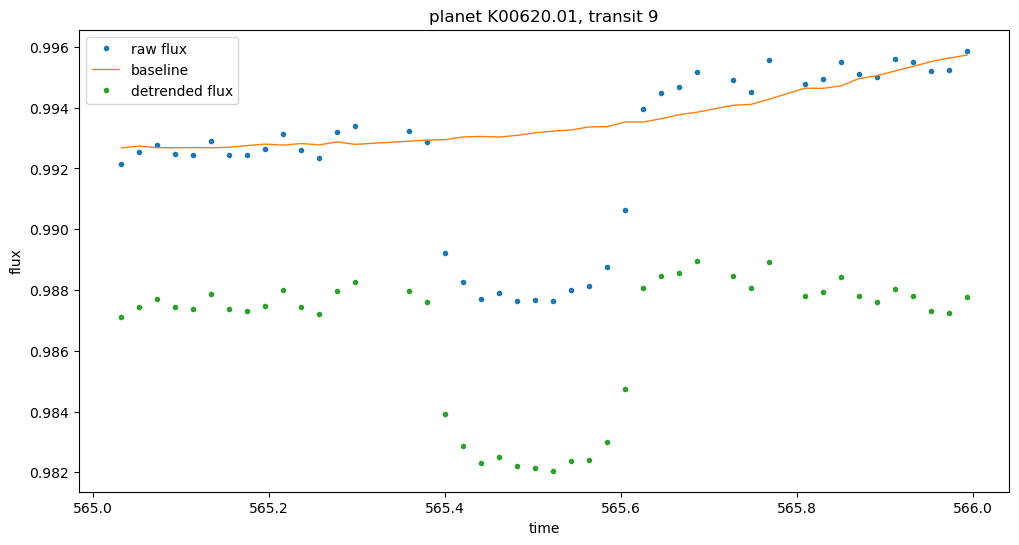

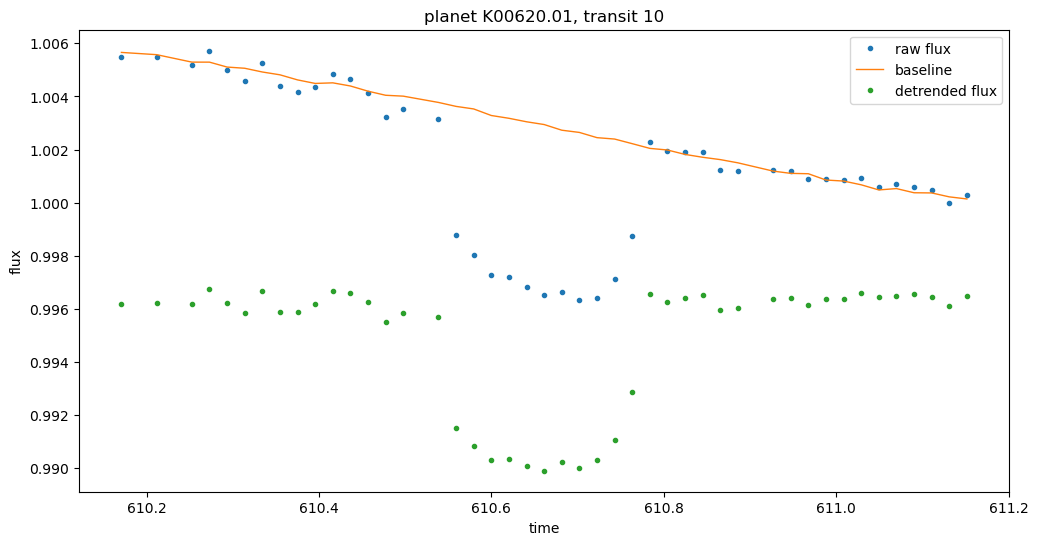

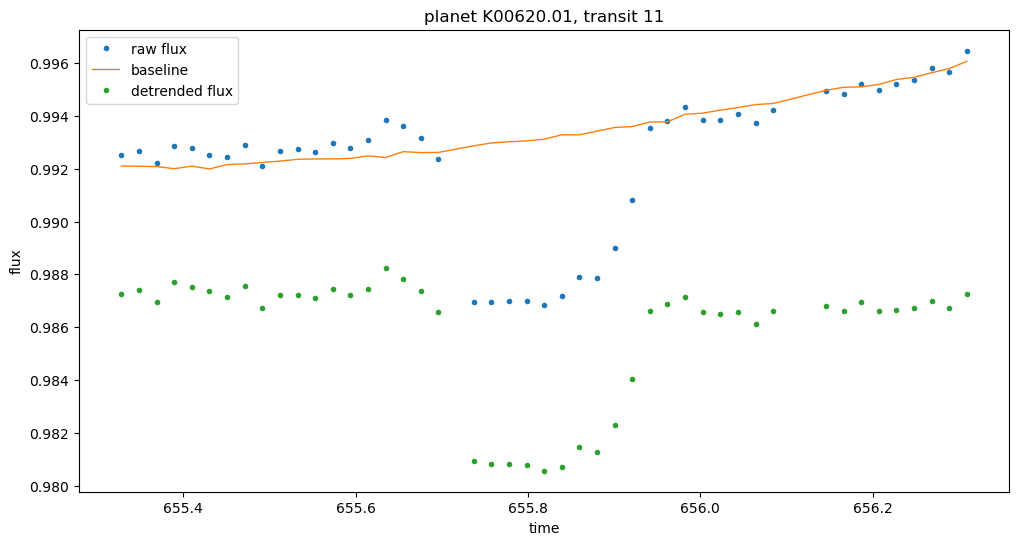

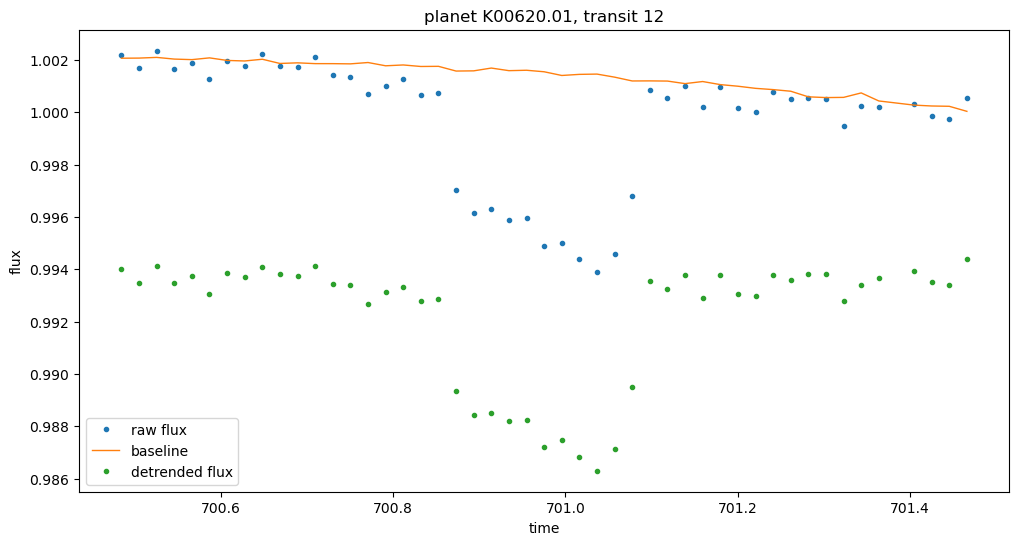

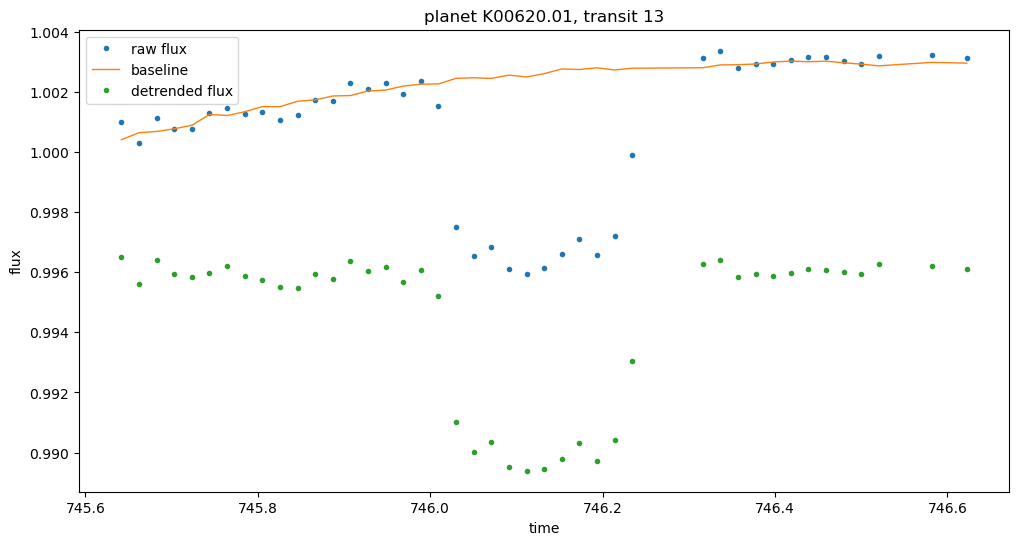

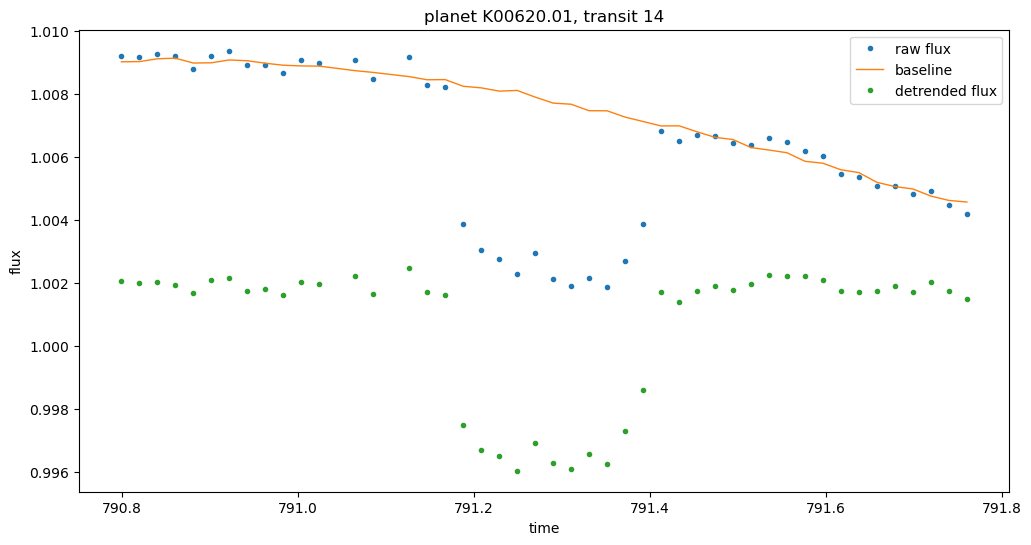

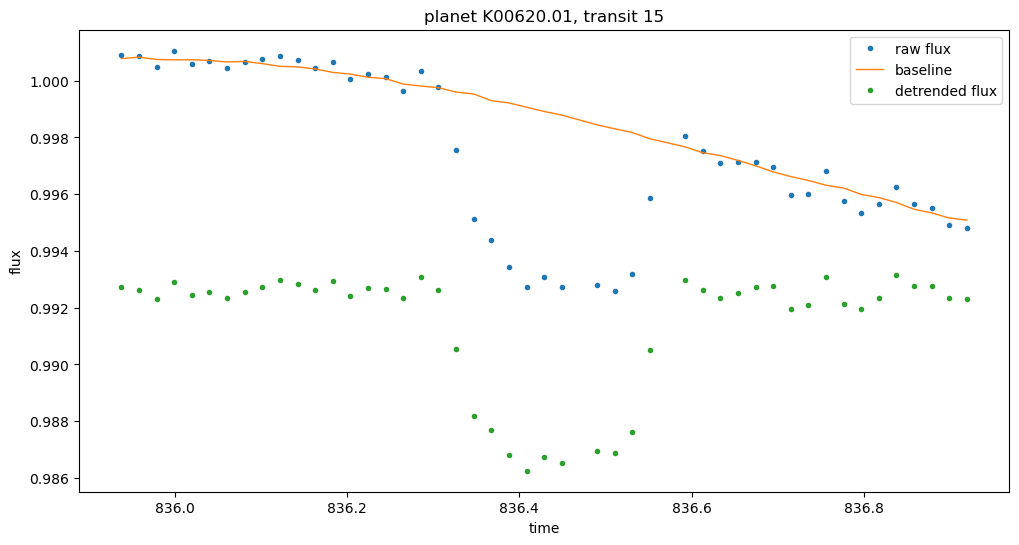

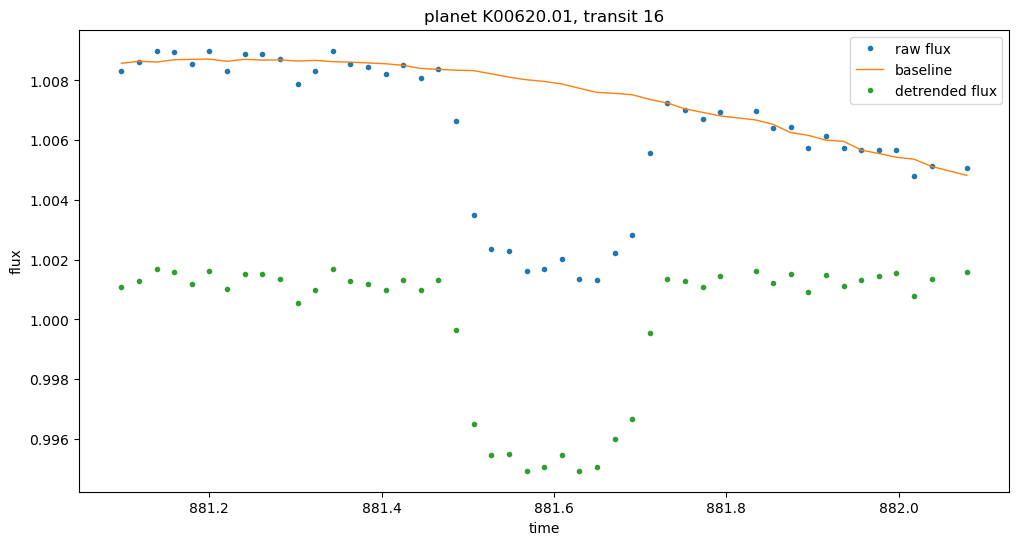

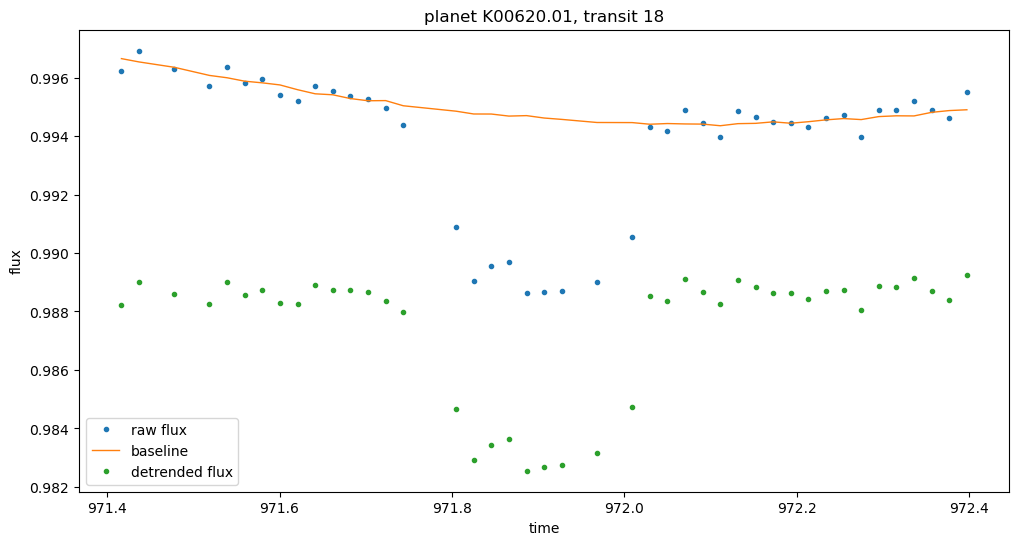

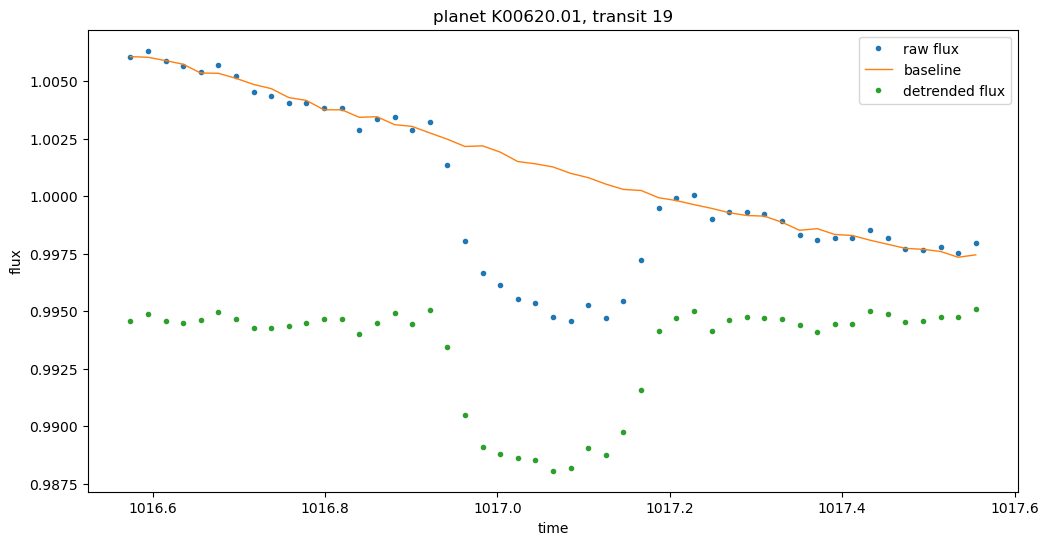

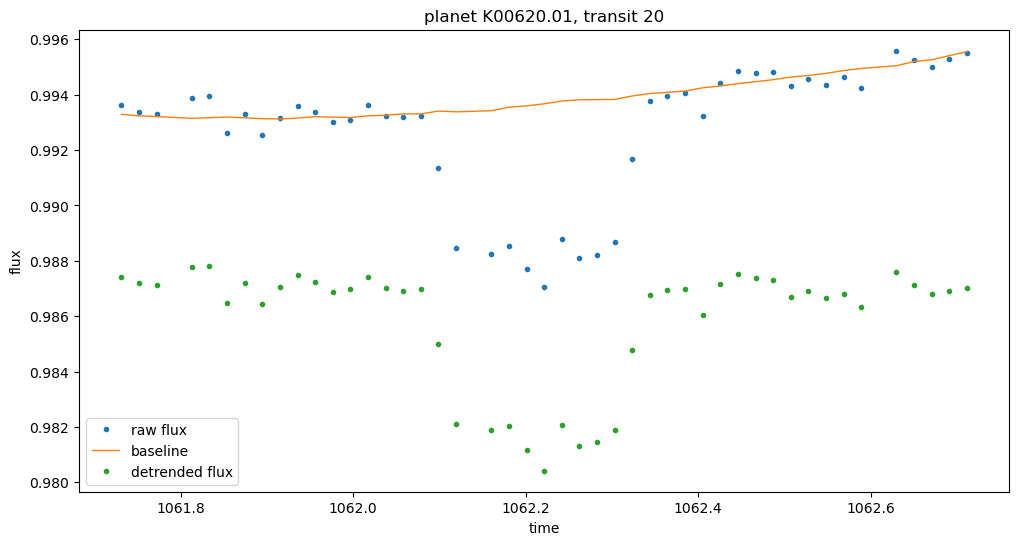

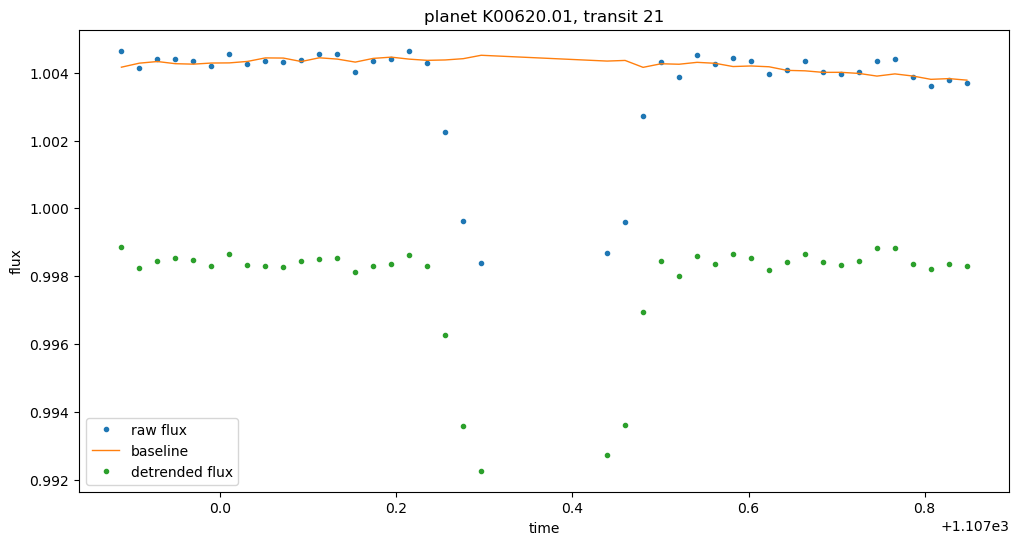

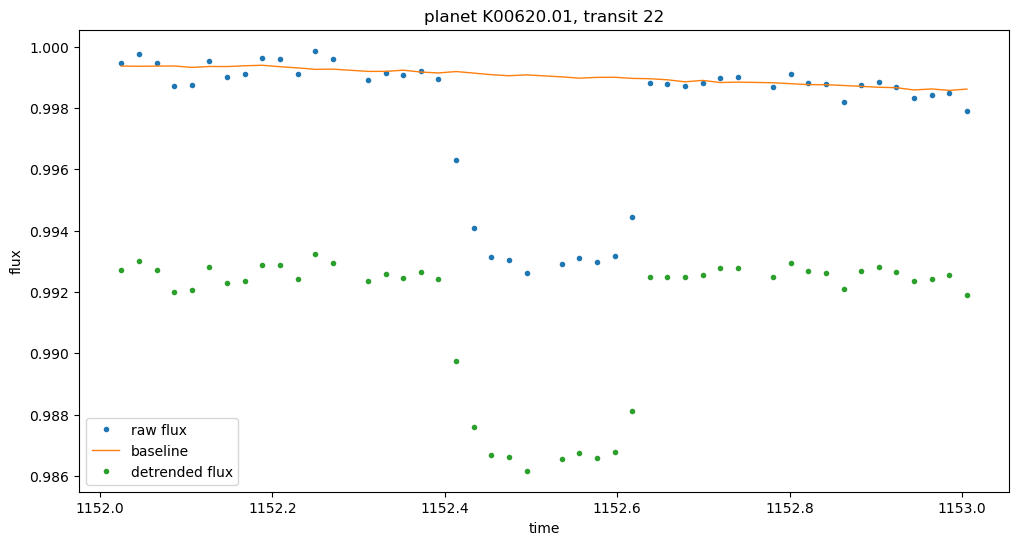

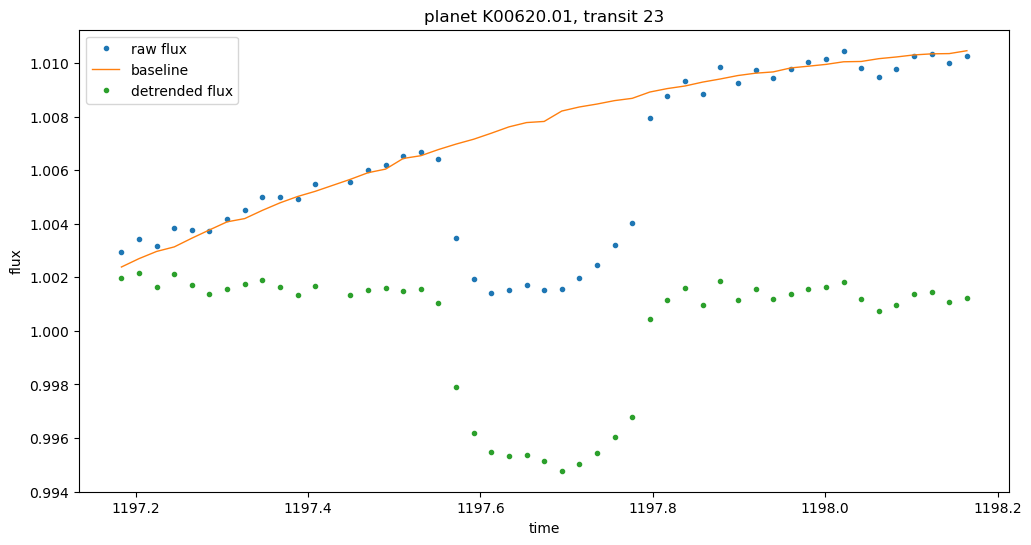

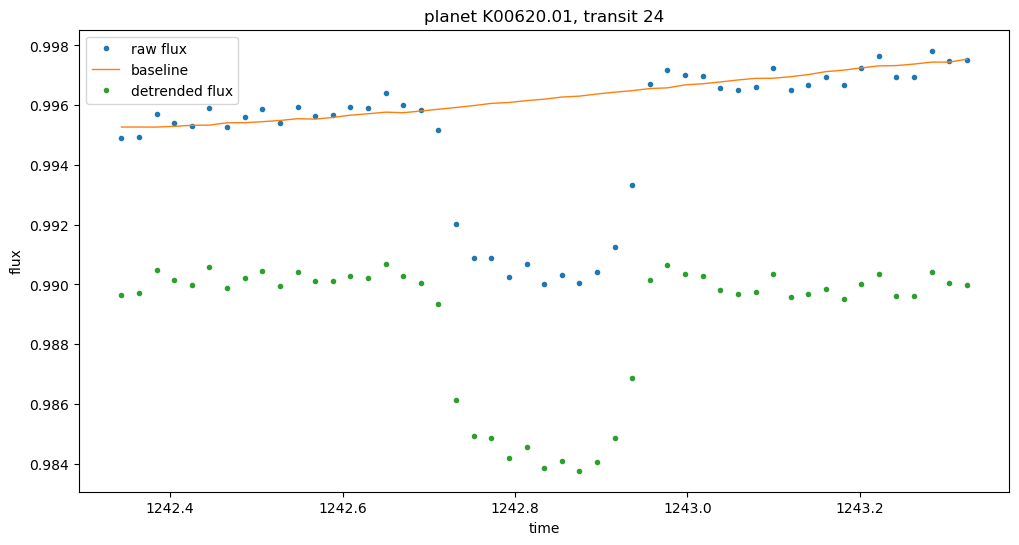

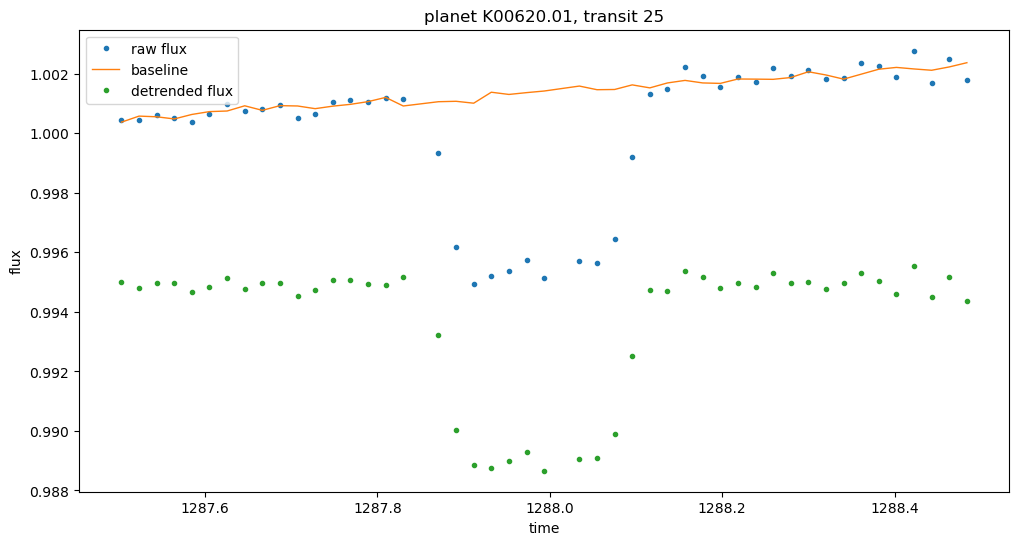

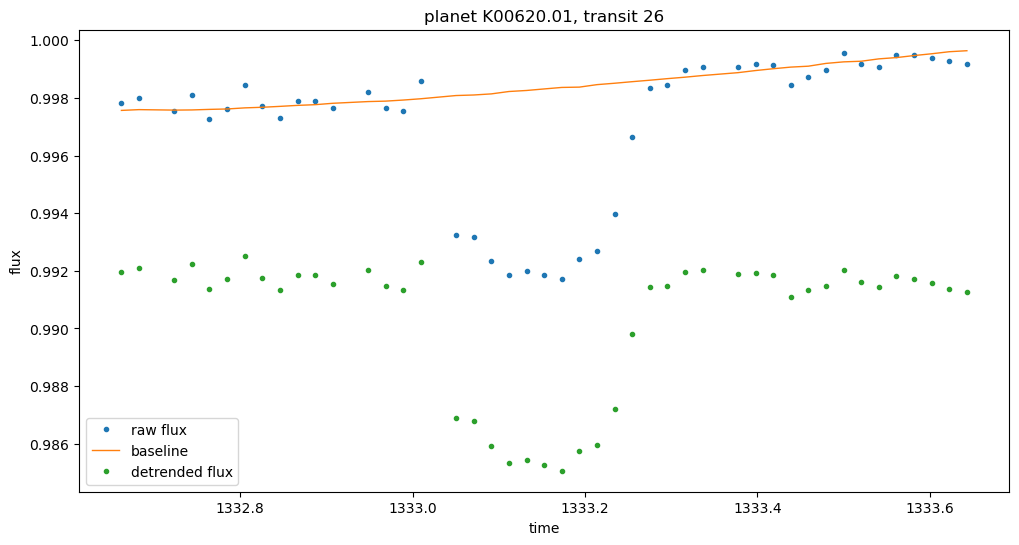

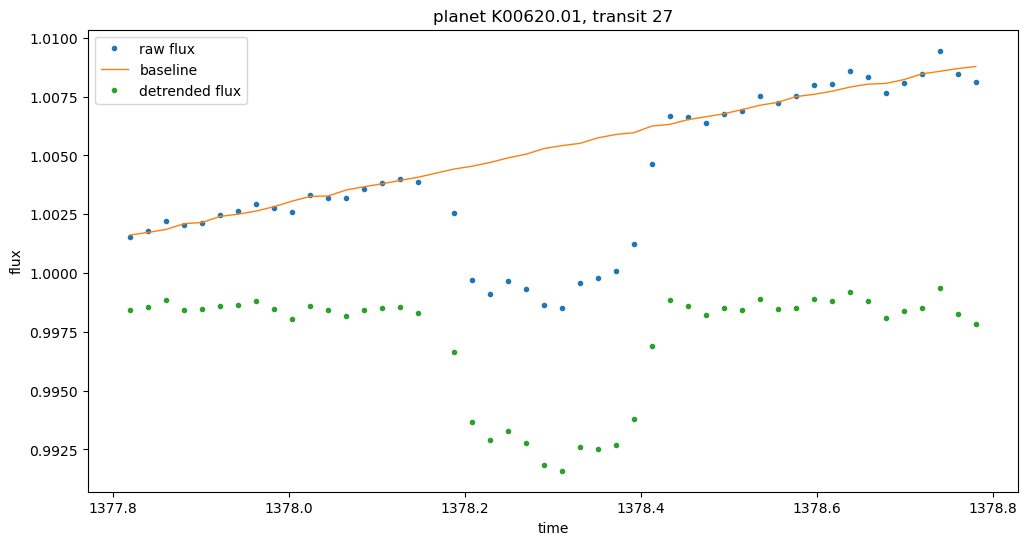

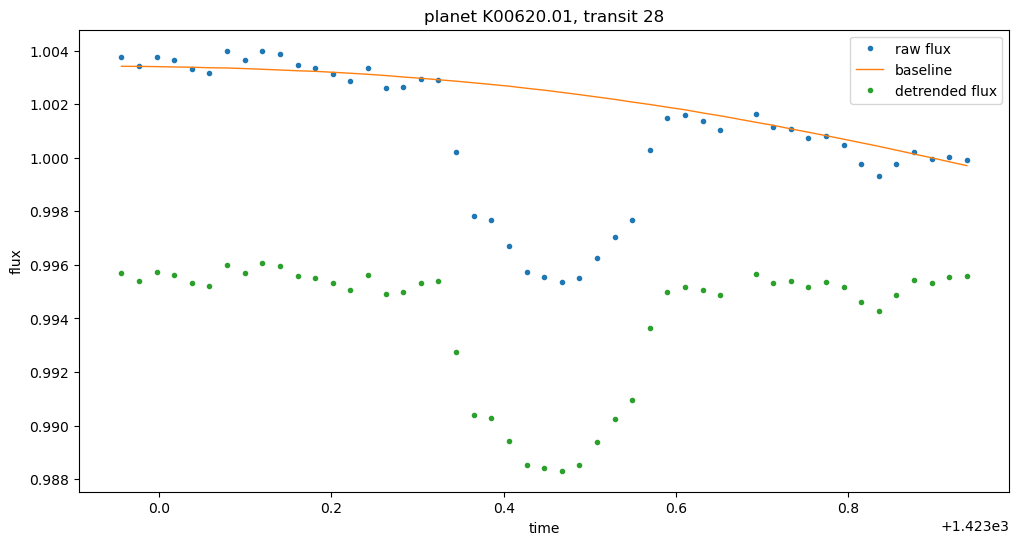

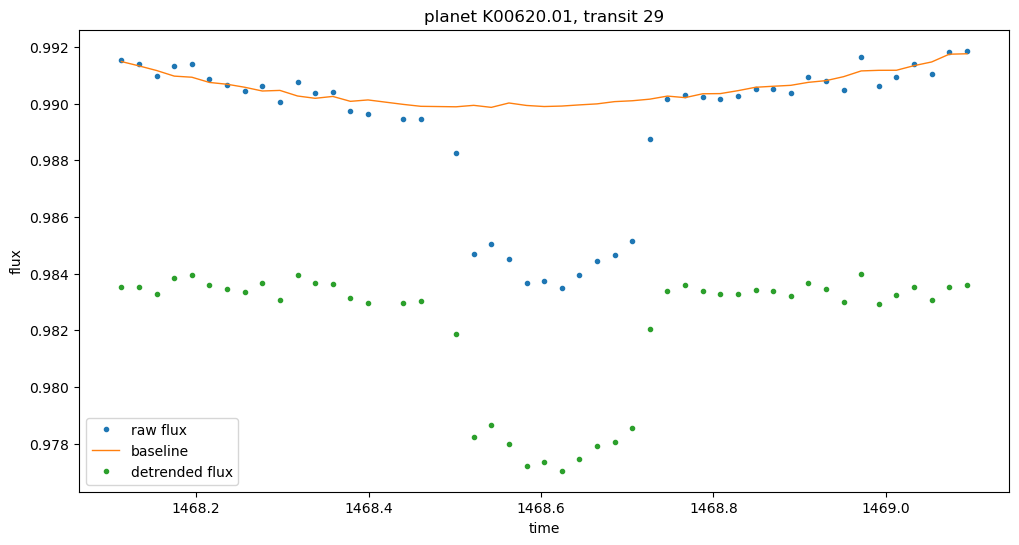

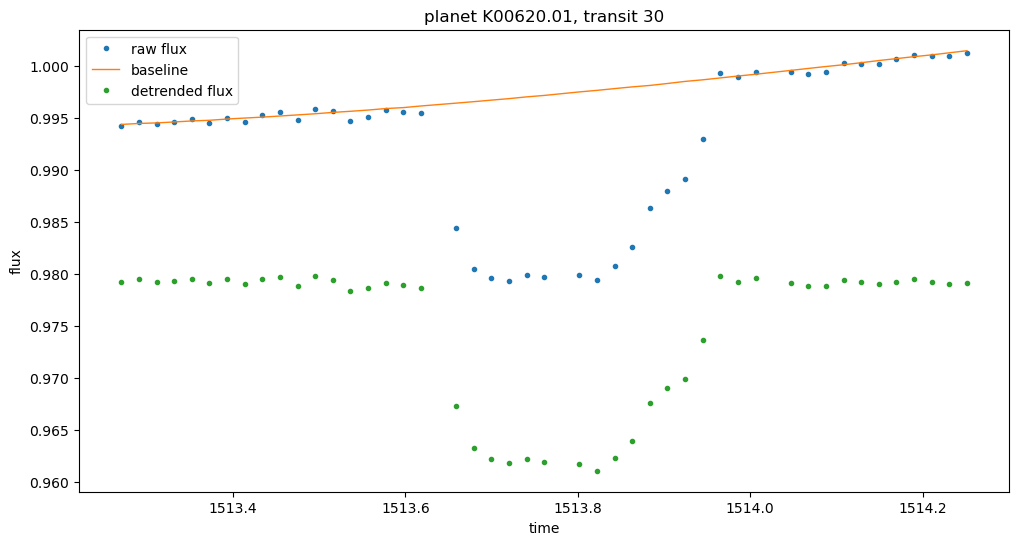

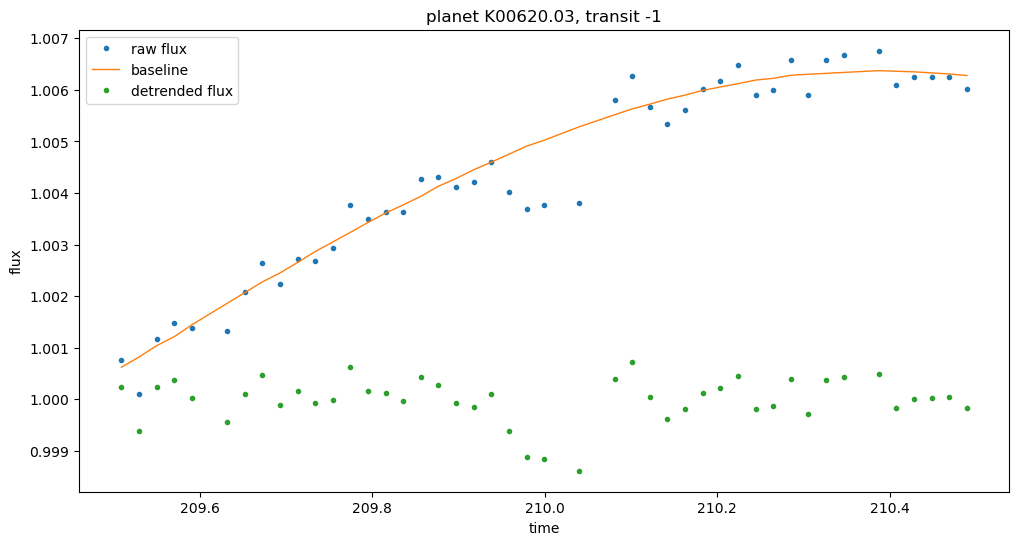

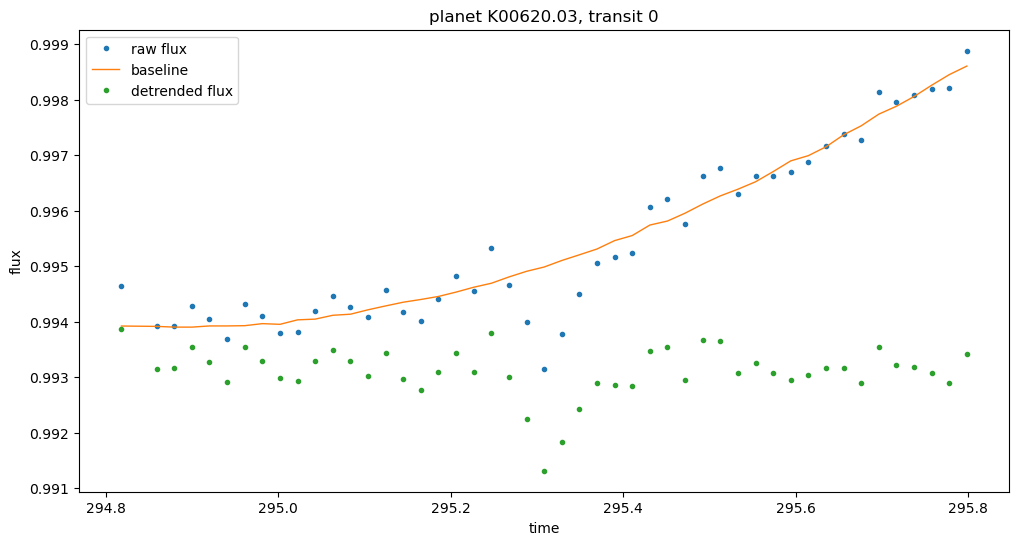

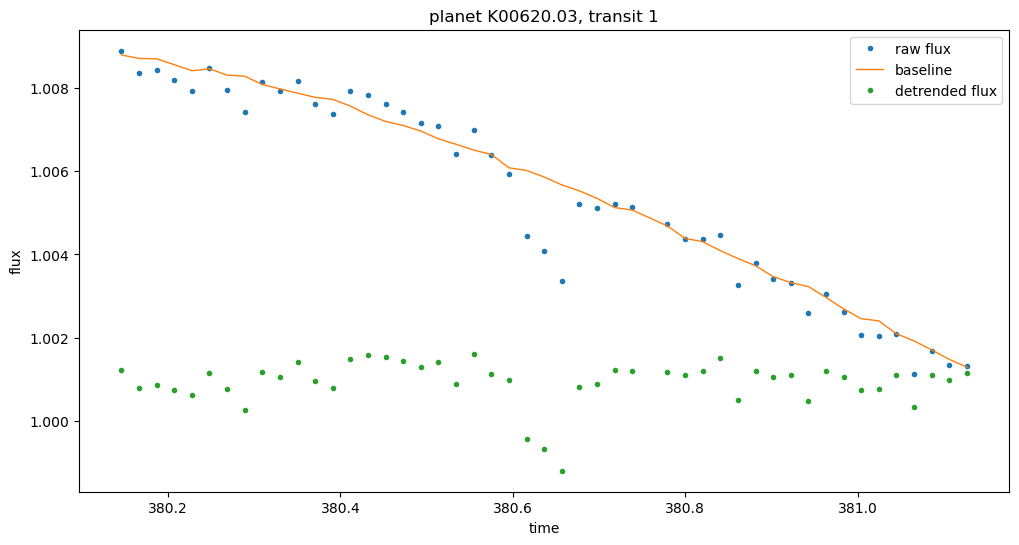

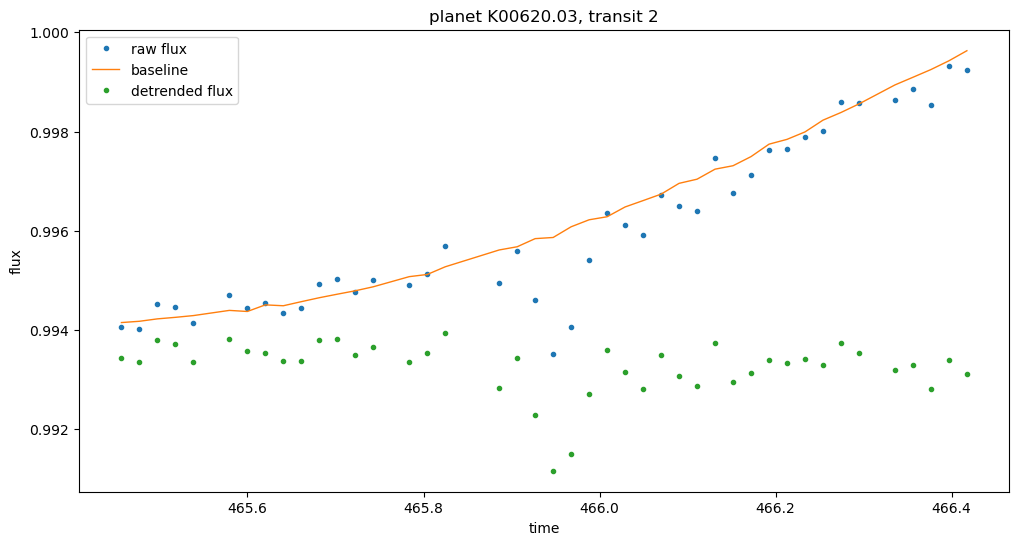

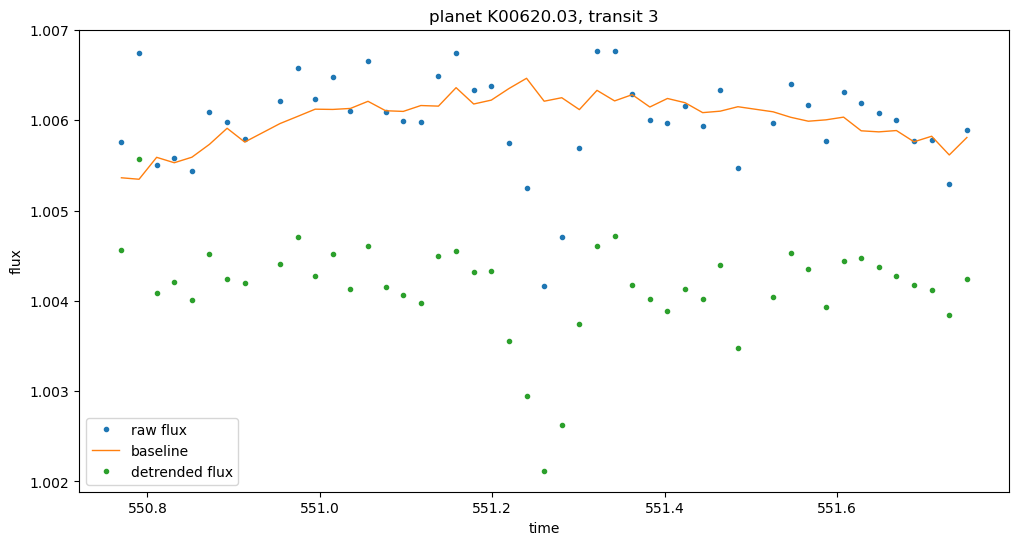

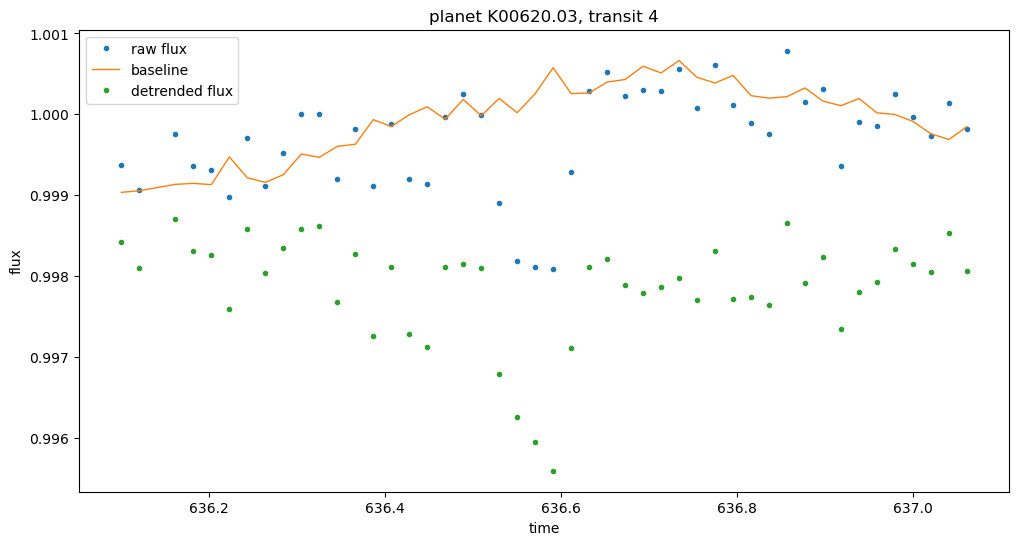

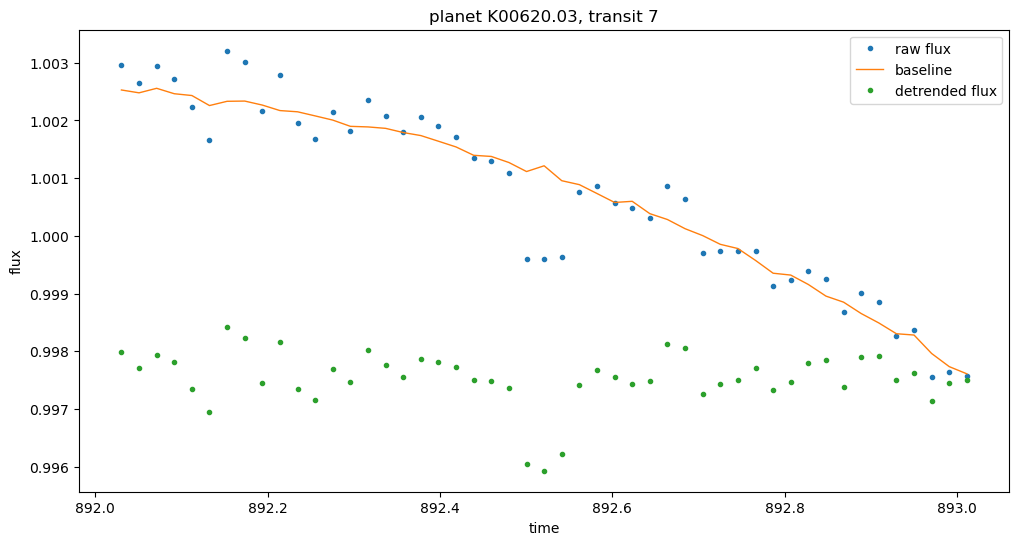

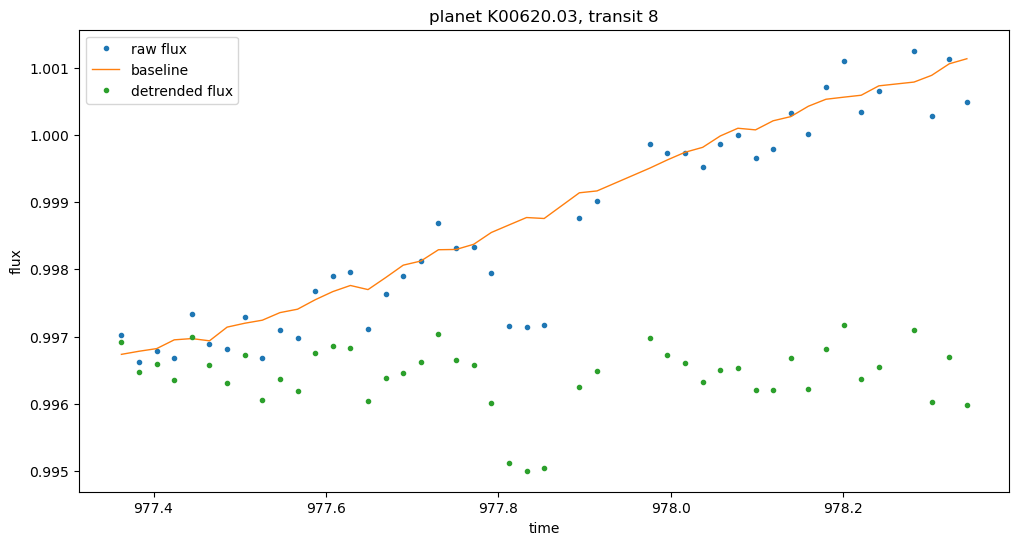

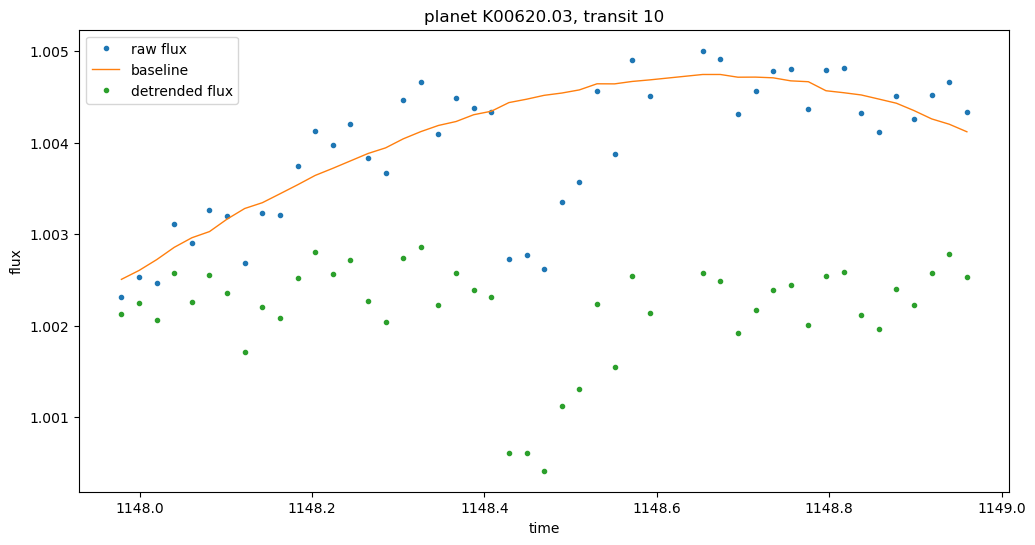

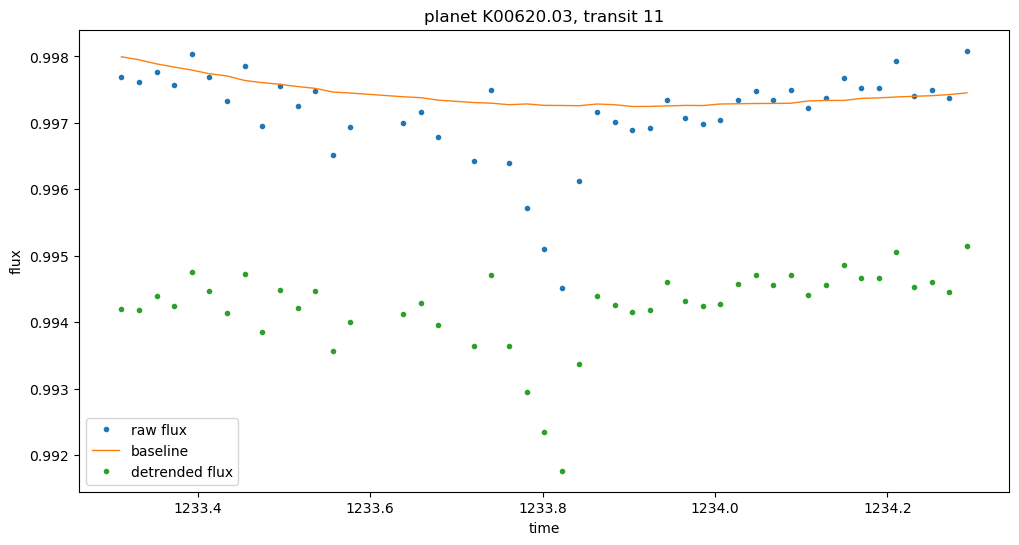

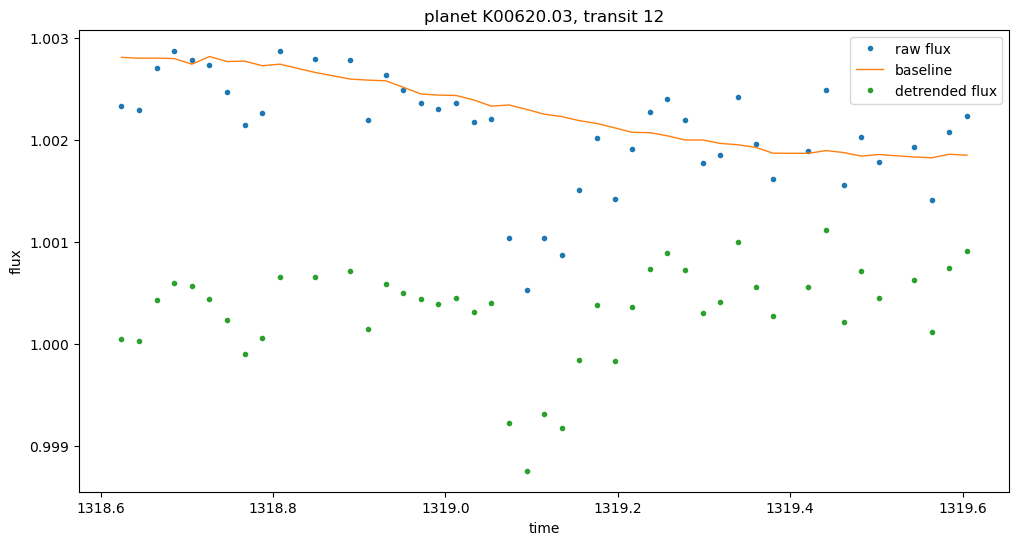

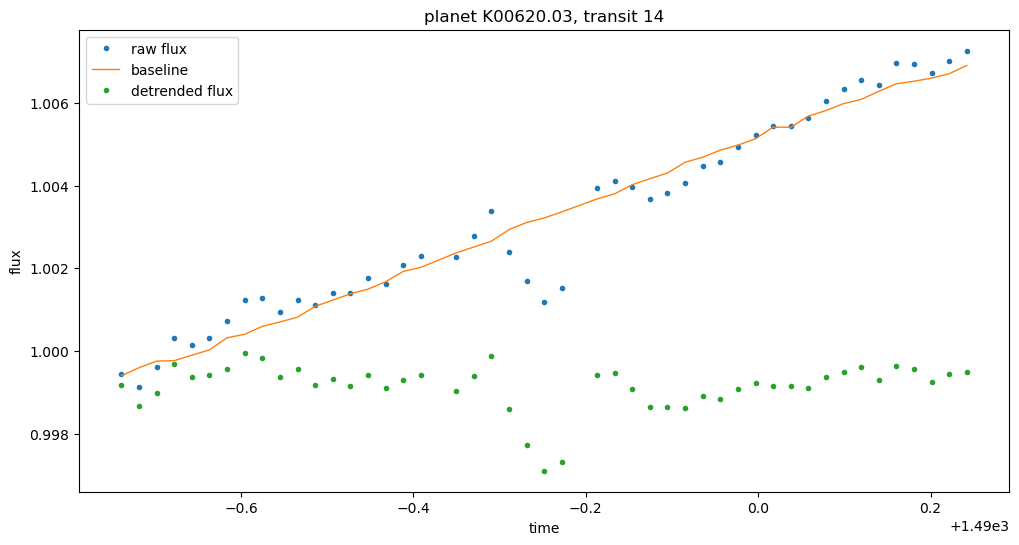

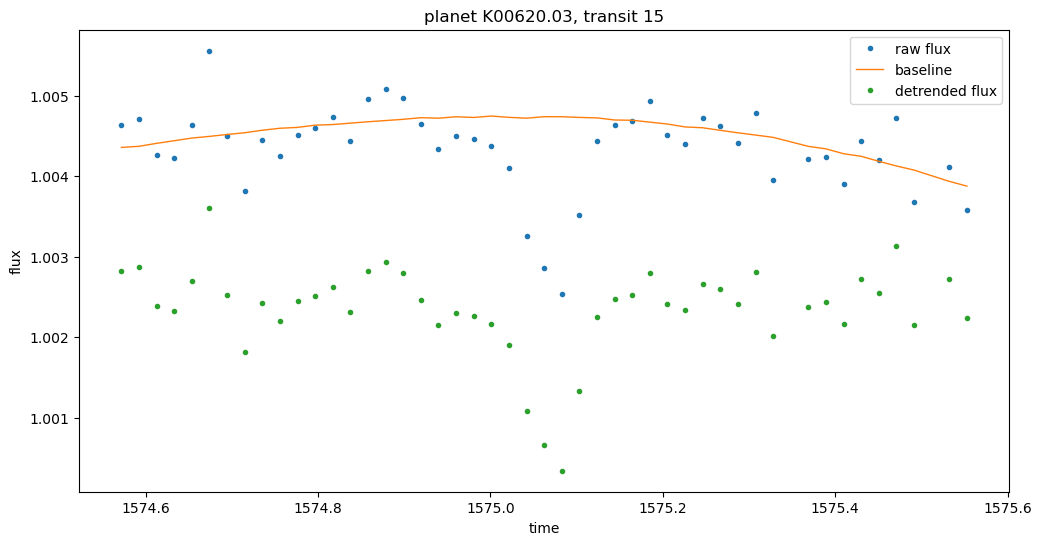

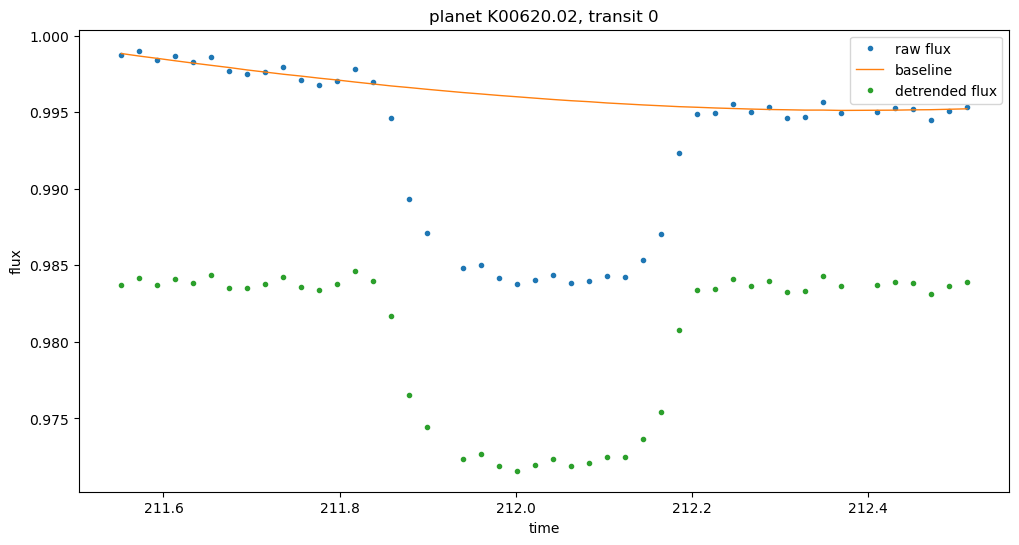

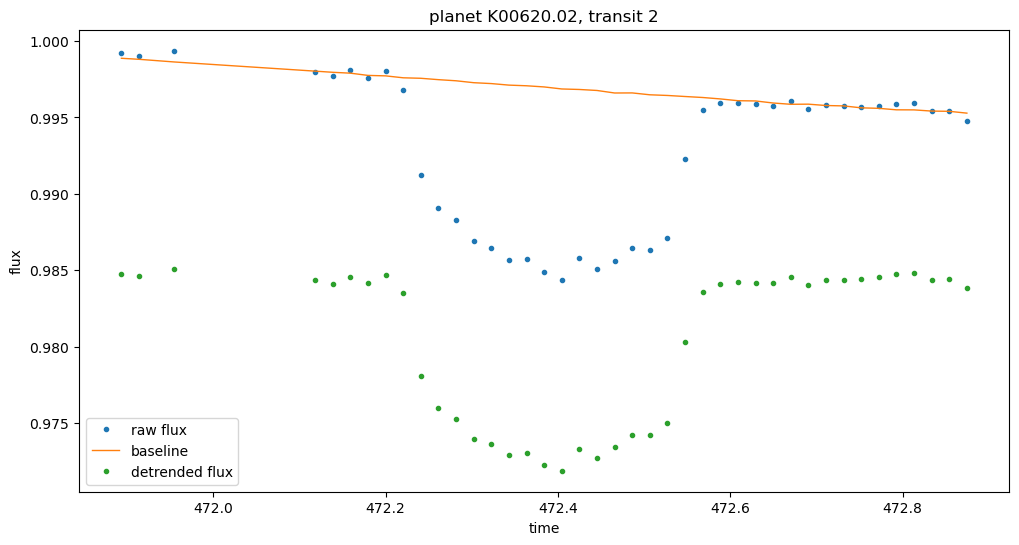

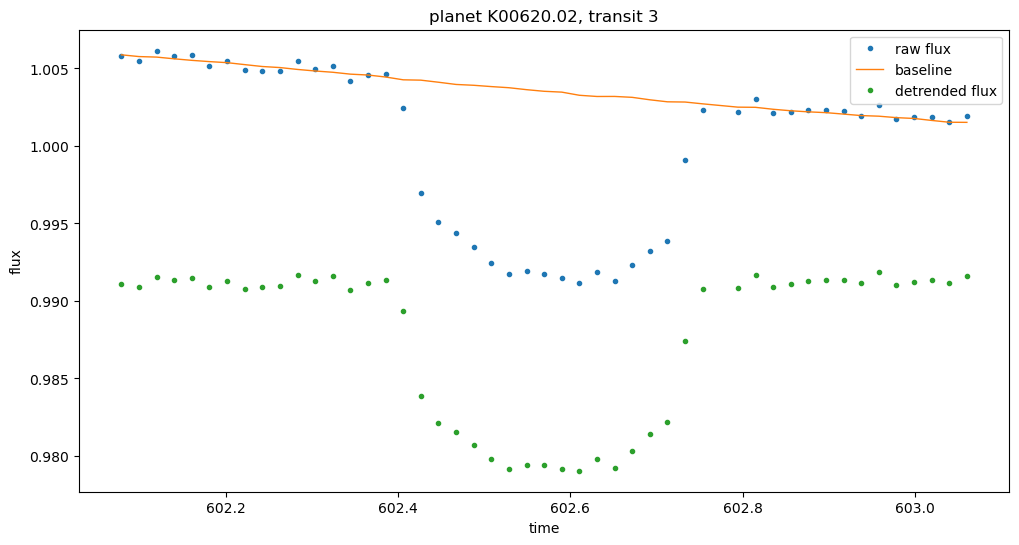

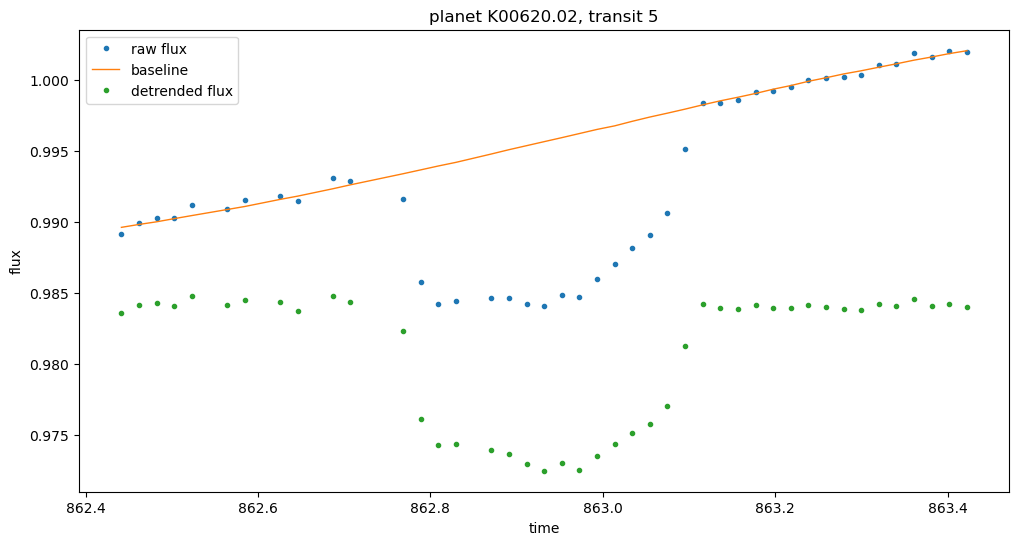

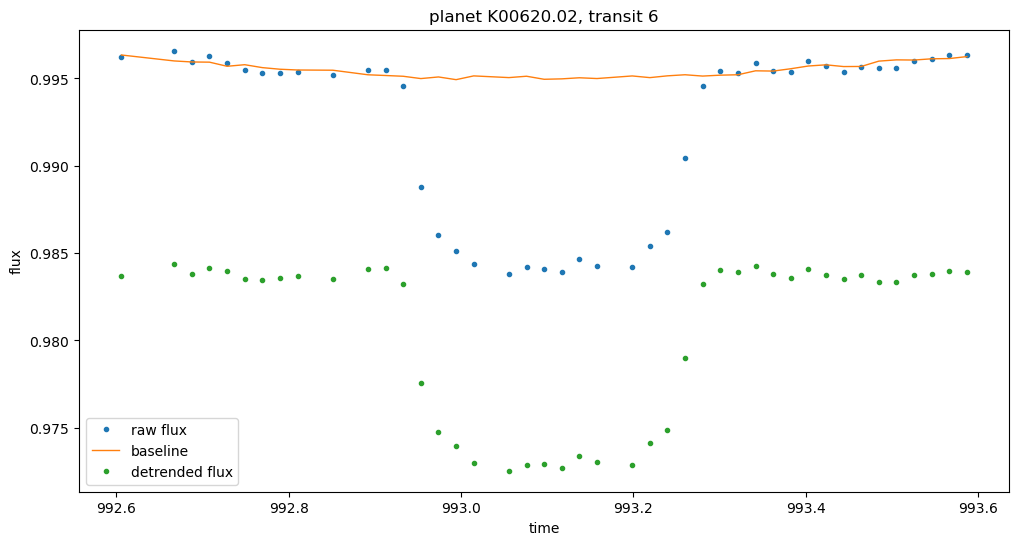

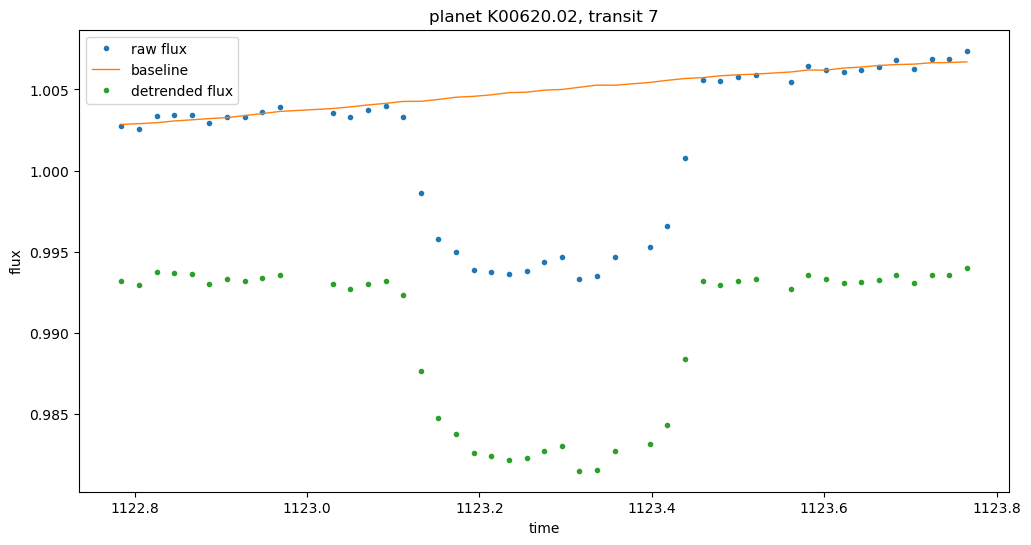

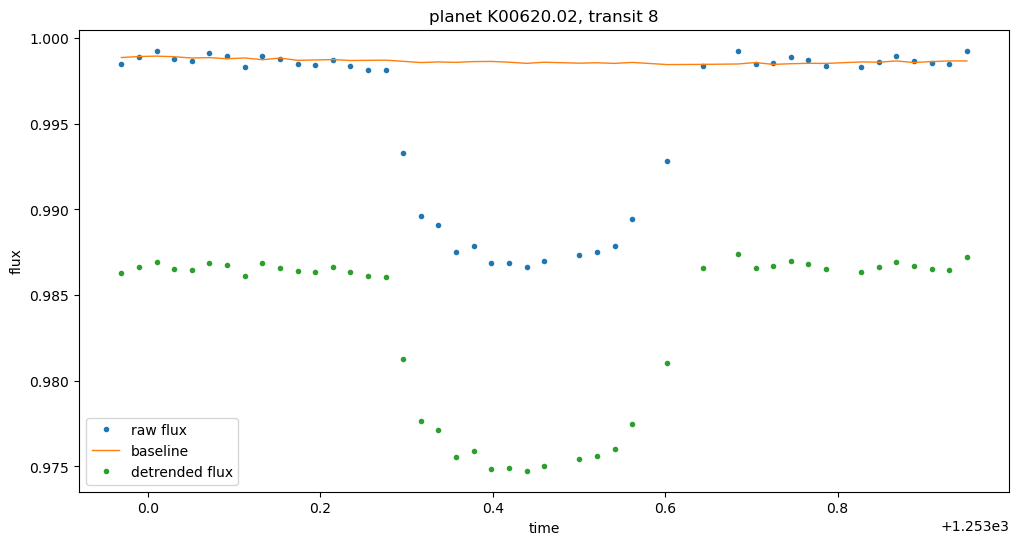

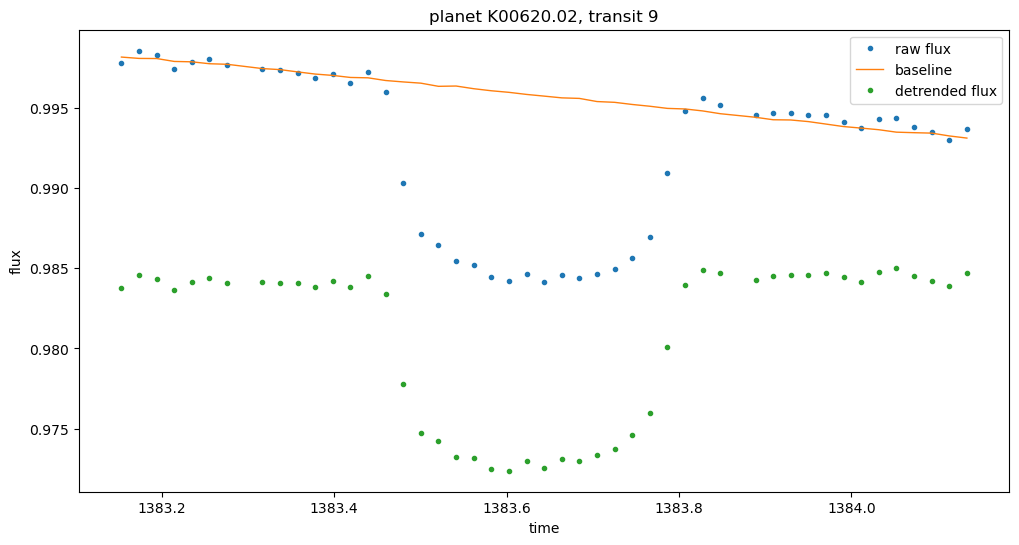

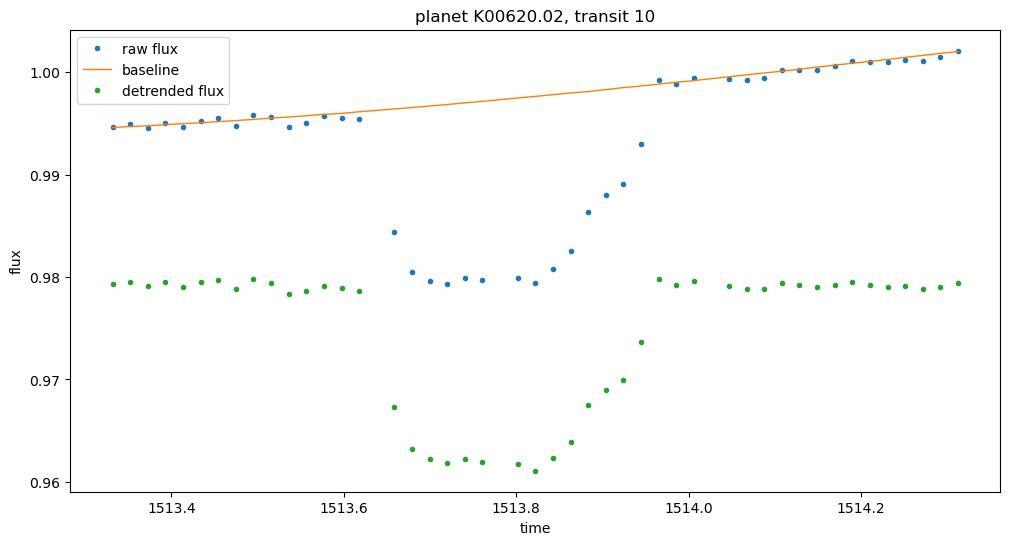

In [18]:
t_out, f_out, e_out = np.array([]), np.array([]), np.array([])
idx_keep = []
for tc, plname, tranum in zip(tcs, plnames, tranums):
    idx = np.abs(t - tc) < time_window
    if np.sum(idx) < minimum_data_frac * 2 * time_window / np.median(np.diff(t)):
        idx_keep.append(False)
        continue
    else:
        idx_keep.append(True)
    t_out = np.r_[t_out, t[idx]]
    f_out = np.r_[f_out, (f-fbase)[idx]]
    e_out = np.r_[e_out, e[idx]]
    plt.figure()
    plt.xlabel("time")
    plt.ylabel("flux")
    plt.title("planet %s, transit %d"%(plname, tranum))
    plt.plot(t[idx], f[idx], ".", label='raw flux')
    plt.plot(t[idx], fbase[idx], "-", lw=1, label='baseline')
    plt.plot(t[idx], (f-fbase)[idx] + np.min(f[idx]), '.', label='detrended flux')
    plt.legend(loc='best')
idx_keep = np.array(idx_keep)

In [19]:
dout = pd.DataFrame(data={"time": t_out, "flux": f_out, "error": e_out})

In [20]:
print (np.sum(dout.duplicated("time")), "overlapping points.")

55 overlapping points.


In [21]:
# remove overlaps
dout = dout.drop_duplicates("time", keep='first').sort_values("time").reset_index(drop=True)

In [22]:
filename_out = "kic%s/kic%s_long_transits.csv"%(kic,kic)

In [23]:
dout.to_csv(filename_out, index=False)